## Question 3: What genetic alterations could improve your engineered cardiomyocytes?

In [4]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co

which: no R in (/home/ec2-user/venv/celloracle/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/home/ec2-user/.local/bin:/home/ec2-user/bin)


In [5]:
# Do setup
co.__version__

plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# Make folders to save plots and links
im_folder = "co_figures"
link_folder = "co_links"

os.makedirs(im_folder, exist_ok=True)
os.makedirs(link_folder, exist_ok=True)

## Data preprocessing

1. Variable gene selection and normalization.

2. Log transformation. 

3. Cell clustering.

4. Dimensional reduction.

In [6]:
def gene_in(list,genename ="Prdm16"):
    for i in list:
        if i == genename:
            print('%s is in preprocessed dataset!'% genename)

In [7]:
def preprocess_pipeline(adata,plot=False): 
    """
    This function preprocessing the scRNA-seq data
    
    """

    # adata.var['mt']= adata.var_names.str.startswith(("mt-"))
    # adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    # Filter out doublets
    thresh = np.percentile(adata.obs['total_counts'],95)
    adata = adata[adata.obs['total_counts'] < thresh, :]
    # Filter out low quality cells 
    # adata = adata[adata.obs['pct_counts_mt'] < 5, :]
    # adata = adata[adata.obs['pct_counts_ribo'] < 35, :]
    # adata = adata[adata.obs['total_counts'] > 10000, :]
    ################################################################################
    # 1. filter out undetected genes that are expressed in less than 5 cells 
    sc.pp.filter_genes(adata, min_cells=5)
    ################################################################################
    # 2. Normalize gene expression matrix with total UMI count per cell
    sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
    ################################################################################
    # 3. Identification of highly variable genes
    # Select top 2000 highly-variable genes
    filter_result = sc.pp.filter_genes_dispersion(adata.X, n_top_genes=3000,log=False)
    # Subset the genes
    adata = adata[:, filter_result.gene_subset]
    # Renormalize after filtering
    sc.pp.normalize_per_cell(adata)
    ################################################################################
    # 4. Log Transform
    # keep raw cont data before log transformation
    adata.raw = adata
    adata.layers["raw_count"] = adata.raw.X.copy()
    # Log transformation and scaling
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    ################################################################################
    # 5. PCA and neighbor calculations
    sc.tl.pca(adata, svd_solver='arpack')
    # Diffusion map
    sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
    sc.tl.diffmap(adata)
    # Calculate neihbors again based on diffusionmap
    sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
    ################################################################################
    # 6. cell clustering 
    sc.tl.louvain(adata, resolution=0.8)
    ################################################################################
    # 7. Dimensionality reduction using PAGA and force-directed graphs
    # PAGA graph construction
    sc.tl.paga(adata, groups='louvain')
    plt.rcParams["figure.figsize"] = [6, 4.5]
    sc.pl.paga(adata)
    sc.tl.draw_graph(adata, init_pos='paga', random_state=123)
    sc.pl.draw_graph(adata, color='louvain', legend_loc='on data')
    adata.write_h5ad("preprocessed_Kannan_perinatal_reference.h5ad")
    gene_in(list(adata.var.index))
    return adata

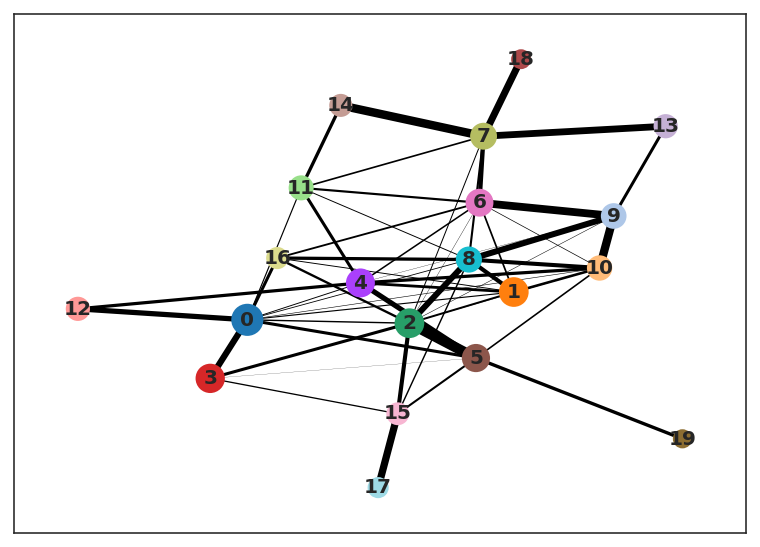

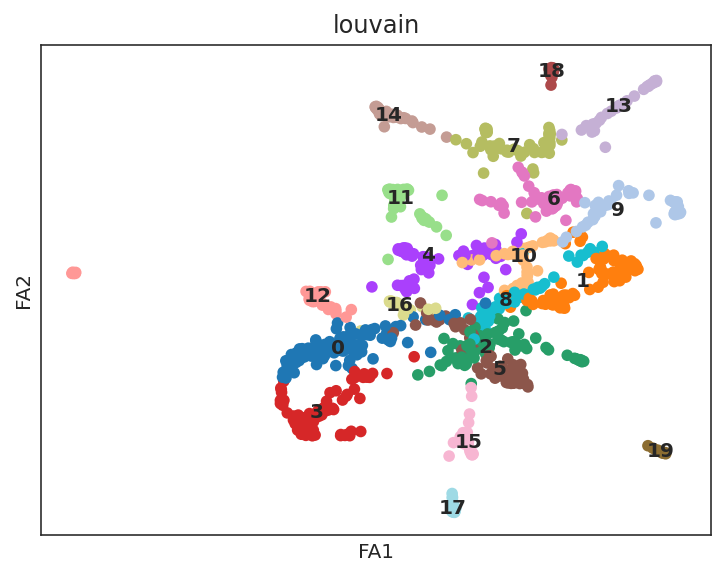

Prdm16 is in preprocessed dataset!


In [8]:
raw_adata = sc.read_h5ad("Kannan_perinatal_reference.h5ad")
adata = preprocess_pipeline(adata=raw_adata)

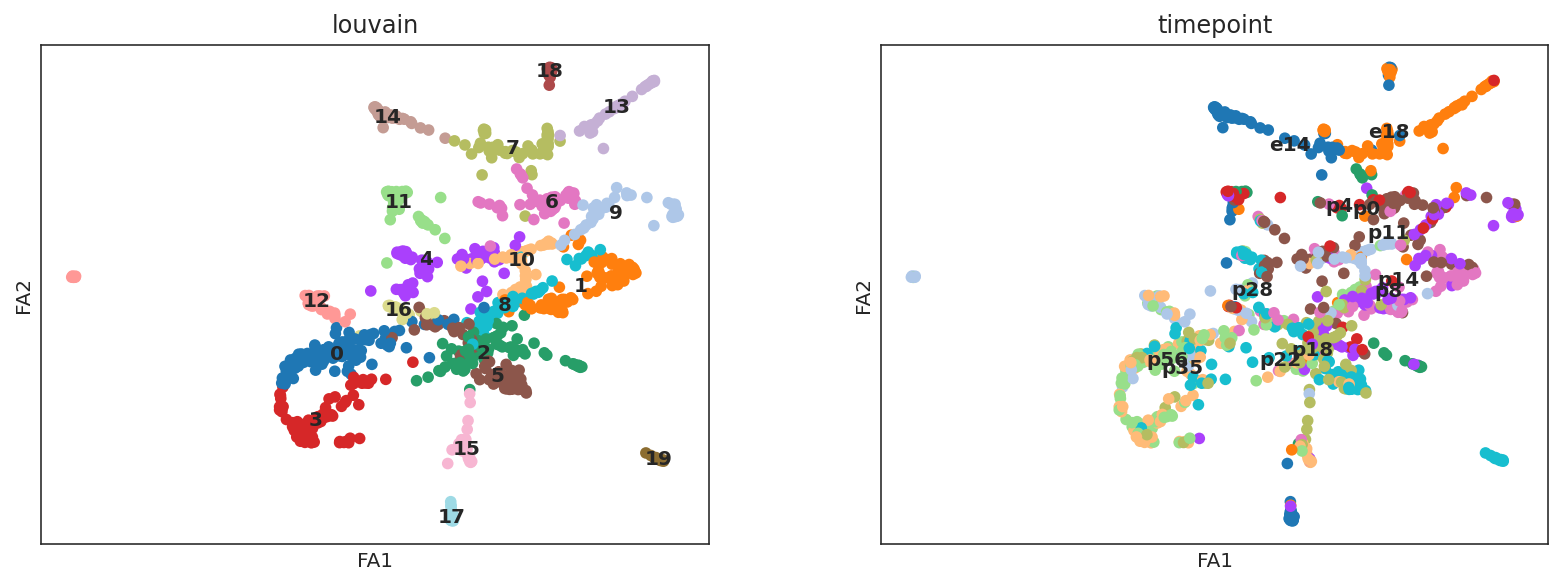

In [9]:
sc.pl.draw_graph(adata, color=['louvain', 'timepoint'],legend_loc='on data')

## Construct GRN model based on default Base-GRN
In order to validate the effectiveness of CellOracle, we will train an oracle on the **Kannan** data.

We would like to turn everything in this section into a single callable function, taking the following inputs:


*   `h5ad` to preprocessed h5ad (QC, clustering, projection) *required*
*   `clusters` used for CellOracle regression *default: louvain*
*   `embedding` used for representation *default: X_draw_graph_fa*
*   `oracle_name` used for saving the oracle/links *default: oracle*

It will have no output, but will save 2 items in the folder it is run in:
*   `{oracle_name}.celloracle.oracle`
*   `{oracle_name}.celloracle.links`


In [48]:
def creat_grn(h5ad = "preprocessed_Kannan_perinatal_reference.h5ad", #put file directory here
              clusters = "timepoint", #change if needed
              embedding = "X_draw_graph_fa", #change if needed
              oracle_name = "Kannan_perinatal" ):
    '''
    Calculate Pearson correlation of 2 anndata matrices
    
    Input:
    --------
        h5ad: to preprocessed h5ad (QC, clustering, projection) *required*
        clusters: used for CellOracle regression *default: louvain*
        embedding: used for representation *default: X_draw_graph_fa*
        oracle_name: used for saving the oracle/links *default: oracle*
    
    Output:
    --------
         None
    '''
    
    adata = sc.read_h5ad(h5ad)
    gene_in(list(adata.var.index))
    # In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
    adata.X = adata.layers["raw_count"].copy()
    #load GRN and create oracle
    base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
    oracle = co.Oracle()
    # Instantiate Oracle object.
    oracle.import_anndata_as_raw_count(adata=adata,
                                       cluster_column_name=clusters,
                                       embedding_name=embedding)
    oracle.import_TF_data(TF_info_matrix=base_GRN)
    # Perform PCA
    oracle.perform_PCA()
    # Select important PCs
    plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
    n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
    plt.axvline(n_comps, c="k")
    print(n_comps)
    n_comps = min(n_comps, 50)
    n_cell = oracle.adata.shape[0]
    k = int(0.025*n_cell)
    print(f"For {n_cell} cells, default k is :{k}")

    oracle.knn_imputation(n_pca_dims=n_comps,
                          k=k,
                          balanced=True,
                          b_sight=k*8,
                          b_maxl=k*4,
                          n_jobs=8) #can change this
    #save
    oracle.to_hdf5(file_path=f"{oracle_name}.celloracle.oracle")
    links = oracle.get_links(cluster_name_for_GRN_unit=clusters,
                         alpha=10,
                         verbose_level=10)
    links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
    links.get_network_score()
    #save filtered links
    for cluster in links.filtered_links.keys():
        links.links_dict[cluster].to_csv(f"{link_folder}/GRN_{cluster}.csv")
    #save these as well.
    links.to_hdf5(file_path=f"{oracle_name}.celloracle.links")


Prdm16 is in preprocessed dataset!


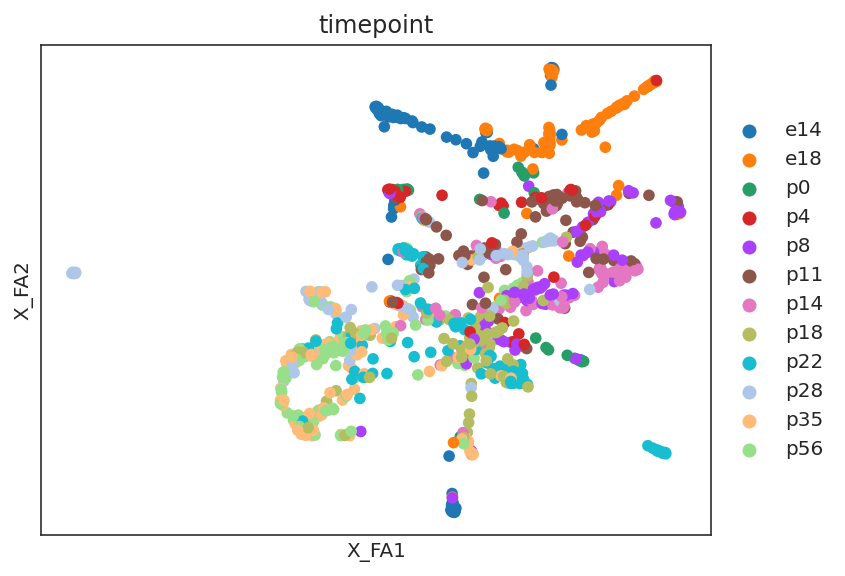

106
For 889 cells, default k is :22


  0%|          | 0/12 [00:00<?, ?it/s]

inferring GRN for e14...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for e18...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p0...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p11...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p14...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p18...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p22...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p28...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p35...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p4...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p56...


  0%|          | 0/2509 [00:00<?, ?it/s]

inferring GRN for p8...


  0%|          | 0/2509 [00:00<?, ?it/s]

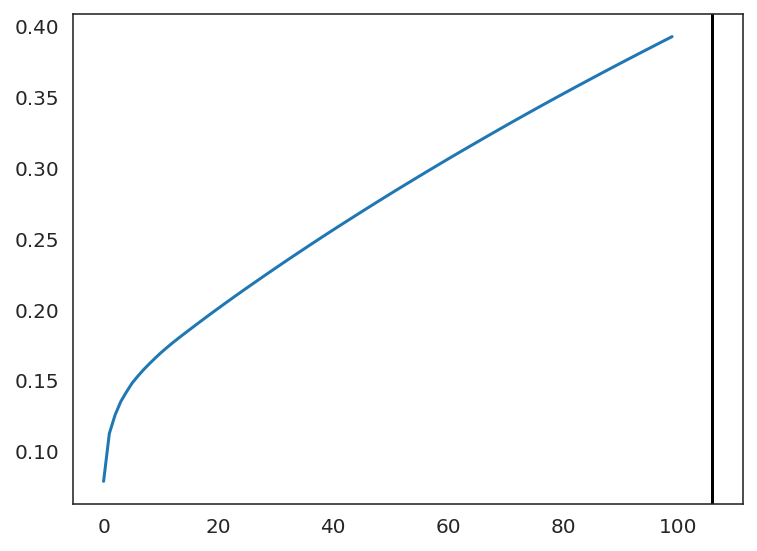

In [11]:
creat_grn()

## Gene network analysis

1. Visualize top n-th genes with high scores in different clusters.

2. By comparing network scores between earlier cluster and late cluster, we can analyze differences in GRN structure. Look at the different genes for the earliest and latest clusters. We would like to improve on the effect by *repressing* the TFs most prominent in early cells and *expressing* the TFs most prominent in late cells. Pick, say, the top 20 differentially linked genes. These will be the shifts we test on the cardiomyocyte oracle.

3. Focus on how a gene’s network score changes during the differentiation. Here we choose Chd2,Zeb1 and Prdm16 as our target genes.


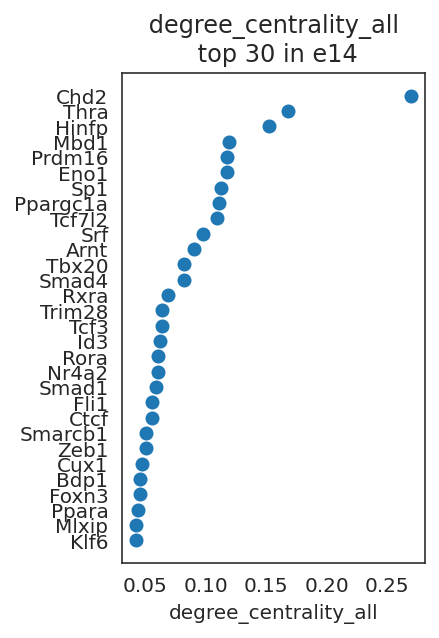

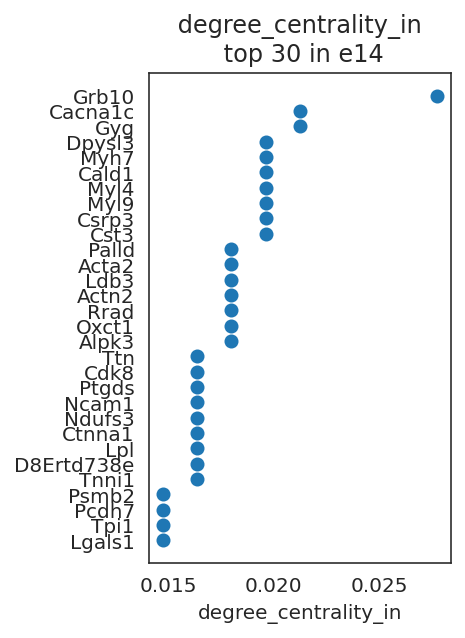

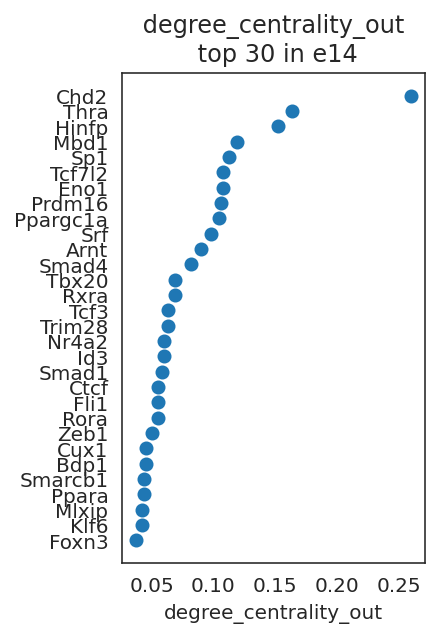

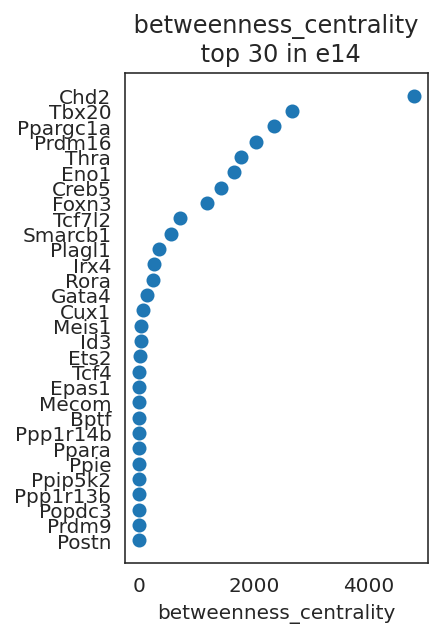

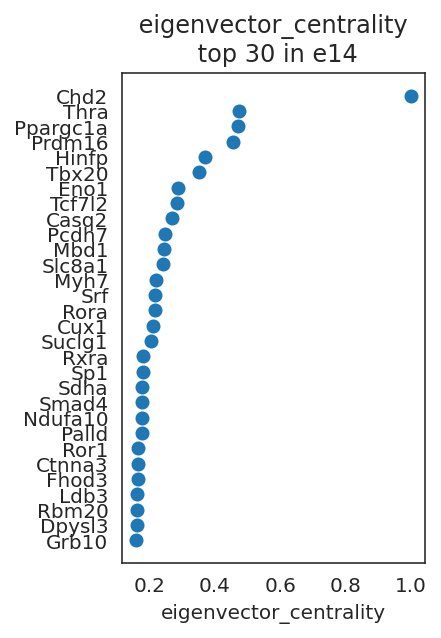

In [16]:
# Visualize top n-th genes with high scores.
links = co.load_hdf5("Kannan_perinatal.celloracle.links")
links.plot_scores_as_rank(cluster="e14", n_gene=30, save=f"ranked_score")

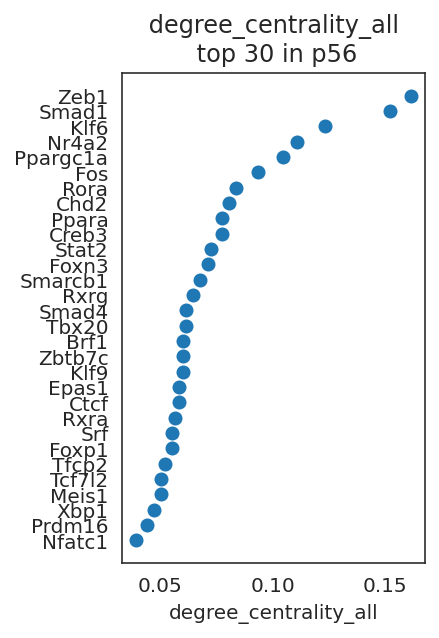

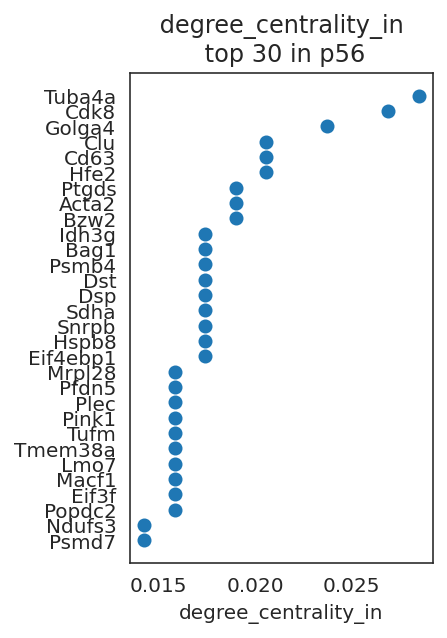

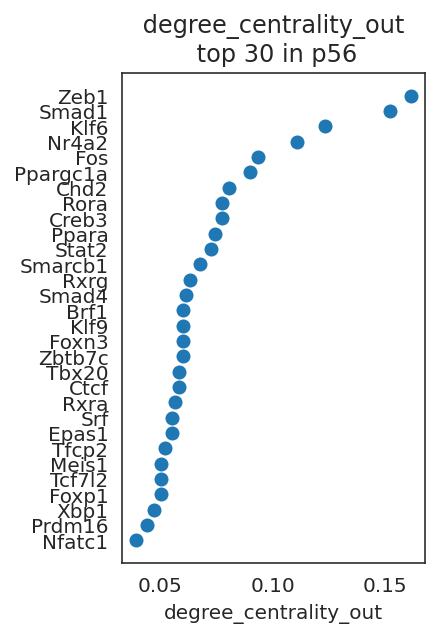

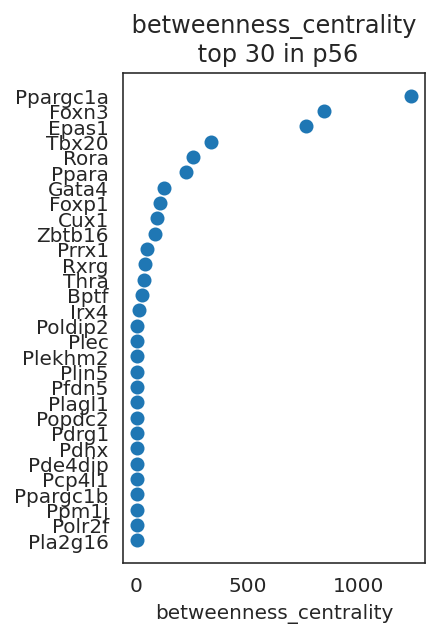

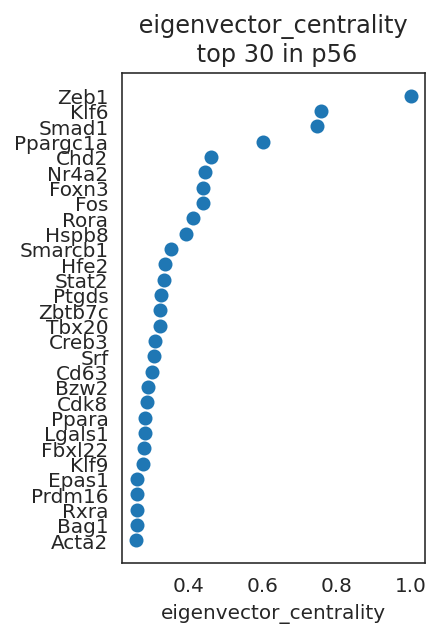

In [17]:
# Visualize top n-th genes with high scores.
links = co.load_hdf5("Kannan_perinatal.celloracle.links")
links.plot_scores_as_rank(cluster="p56", n_gene=30, save=f"ranked_score")

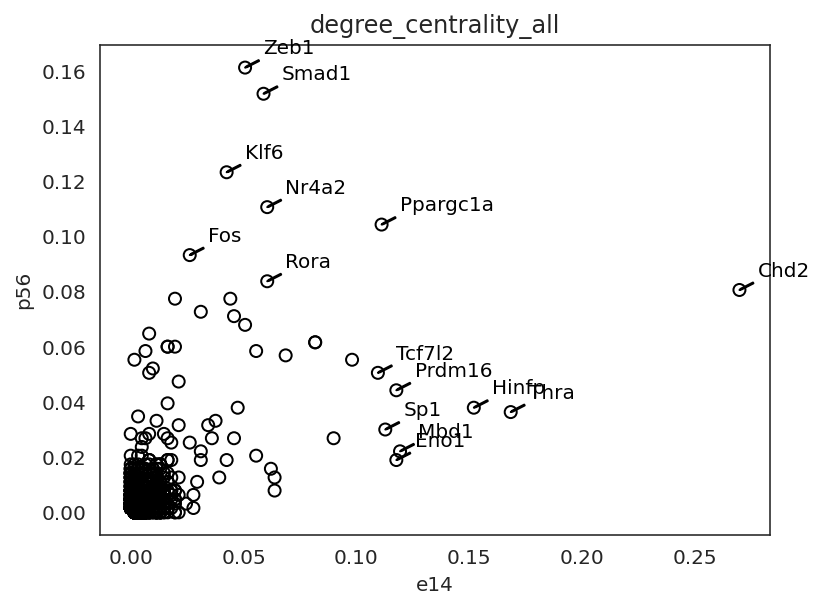

In [18]:
early_cluster = 'e14' #put Kannan early cluster name here
late_cluster = 'p56' #put Kannan late cluster name here
value = "degree_centrality_all"
links.plot_score_comparison_2D(value,
                               early_cluster,
                               late_cluster,
                               percentile=99,
                               annot_shifts=None,
                               save=f"{early_cluster}_{late_cluster}.png",
                               plt_show=True,
                               interactive=False)

Chd2


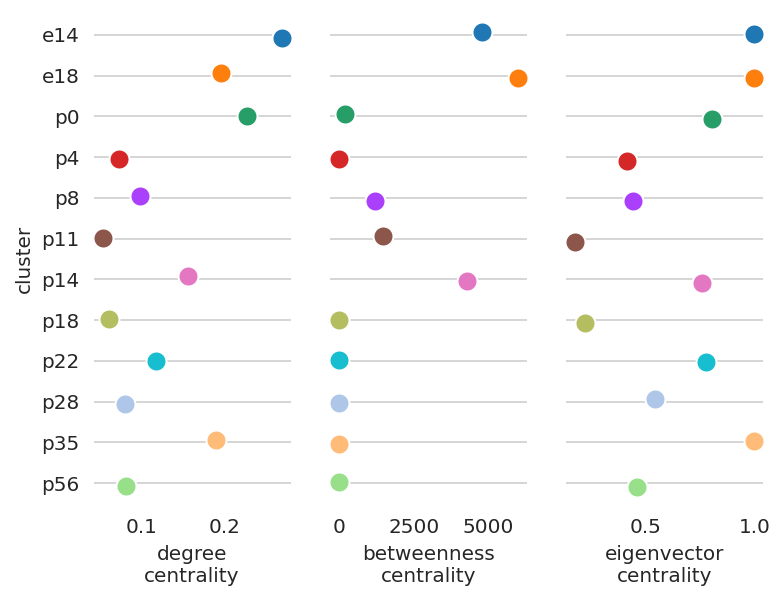

In [19]:
# Visualize Chd2 network score dynamics
links.plot_score_per_cluster(goi="Chd2", save=f"network_score_Chd2/")

Zeb1


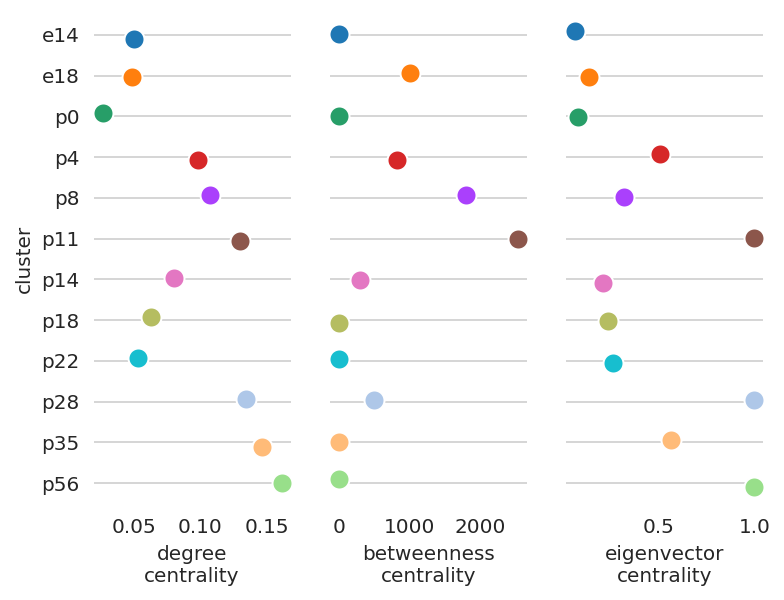

In [20]:
# Visualize Zeb1 network score dynamics
links.plot_score_per_cluster(goi="Zeb1", save=f"network_score_Zeb1/")

Prdm16


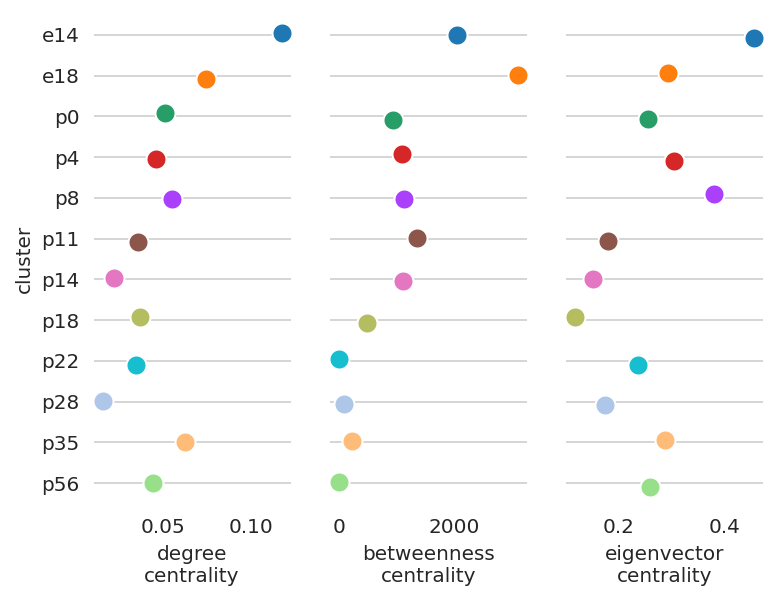

In [21]:
# Visualize Prdm16 network score dynamics
links.plot_score_per_cluster(goi="Prdm16", save=f"network_score_Prdm16/")

## Run in silico TF perturbations with the GRN models
1. Use the GRN model to simulate cell identity shifts in response to TF perturbation. In this part we create a **Prdm16-KO** model.

2. Compare simulation vectors with developmental vectors. First, we will calculate a pseudotime gradient vector field to recapitulate the developmental flow. Then, we will compare the CellOracle TF perturbation vector field with the developmental vector field by calculating the inner product scores. 


In [22]:
oracle = co.load_hdf5("Kannan_perinatal.celloracle.oracle")
links = co.load_hdf5("Kannan_perinatal.celloracle.links")

In [23]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in e14


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1449 genes
calculating GRN in e18


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1509 genes
calculating GRN in p0


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1217 genes
calculating GRN in p11


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1481 genes
calculating GRN in p14


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1395 genes
calculating GRN in p18


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1239 genes
calculating GRN in p22


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1283 genes
calculating GRN in p28


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1379 genes
calculating GRN in p35


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1253 genes
calculating GRN in p4


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1377 genes
calculating GRN in p56


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1279 genes
calculating GRN in p8


  0%|          | 0/2999 [00:00<?, ?it/s]

genes_in_gem: 2999
models made for 1332 genes


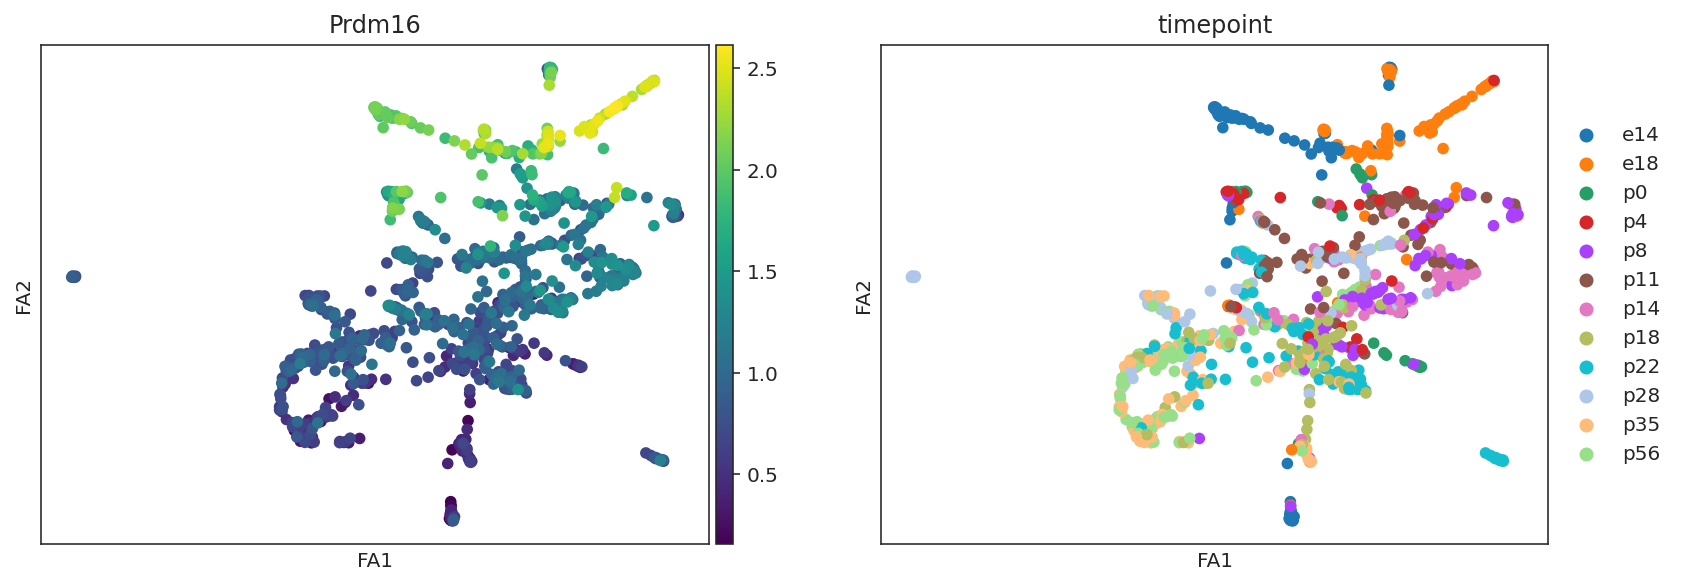

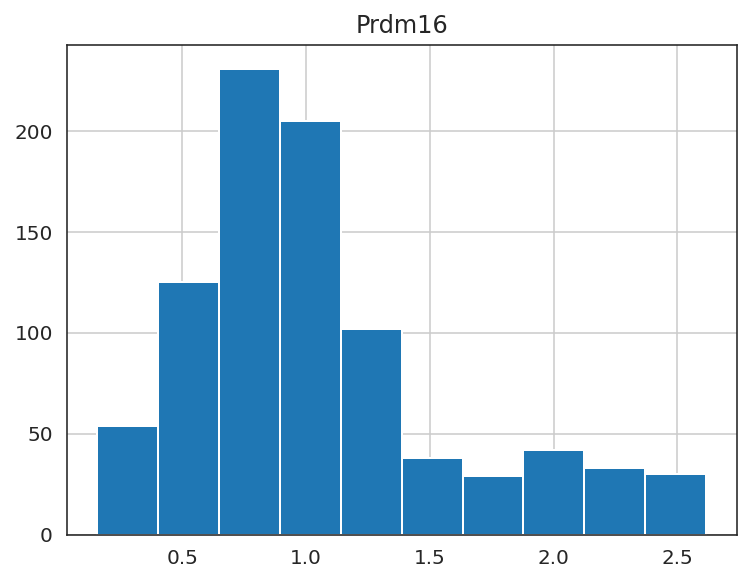

In [24]:
goi = "Prdm16"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [25]:
gene = "Prdm16"
oracle.simulate_shift(perturb_condition={gene: 0.0},
                      n_propagation=3)
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)
# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

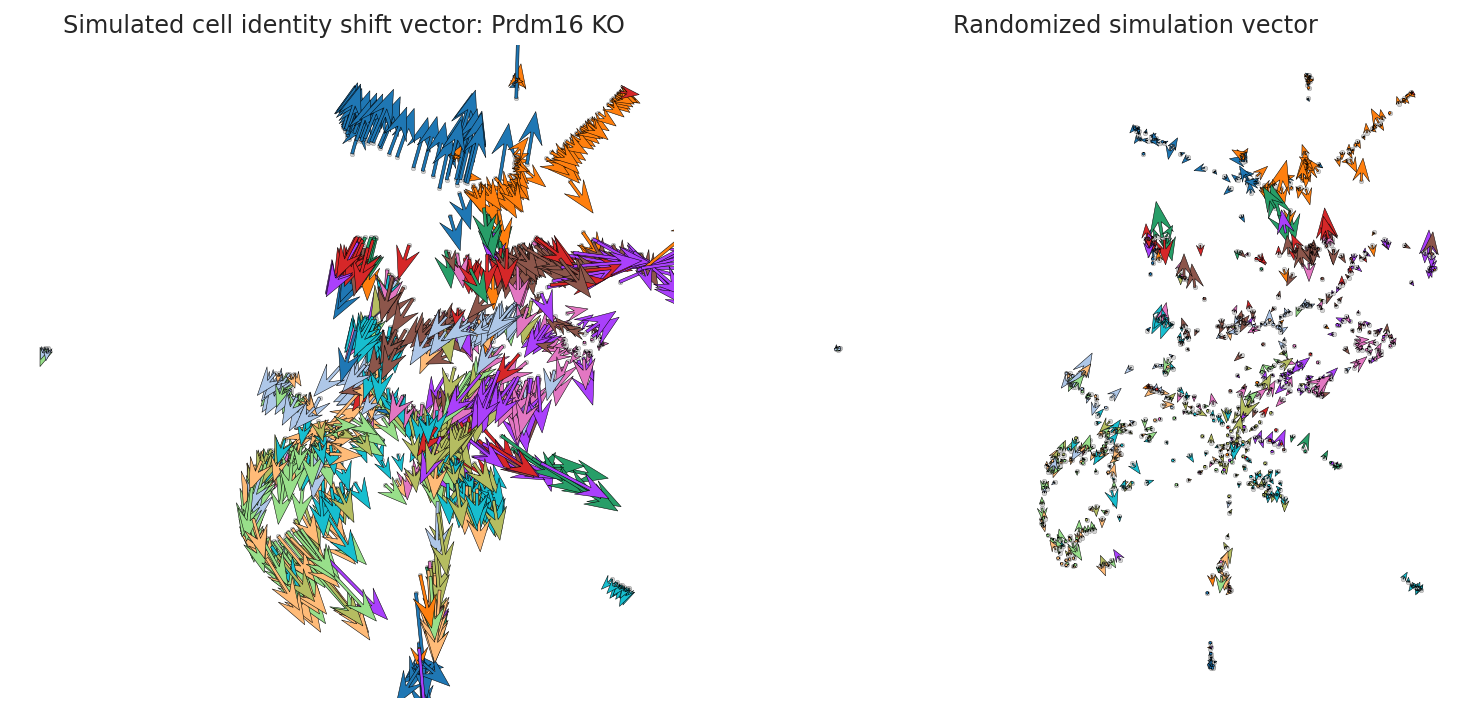

In [26]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])
oracle.embedding = oracle.adata.obsm["X_draw_graph_fa"]

scale = 10
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [27]:
# n_grid = 40 is a good starting value.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

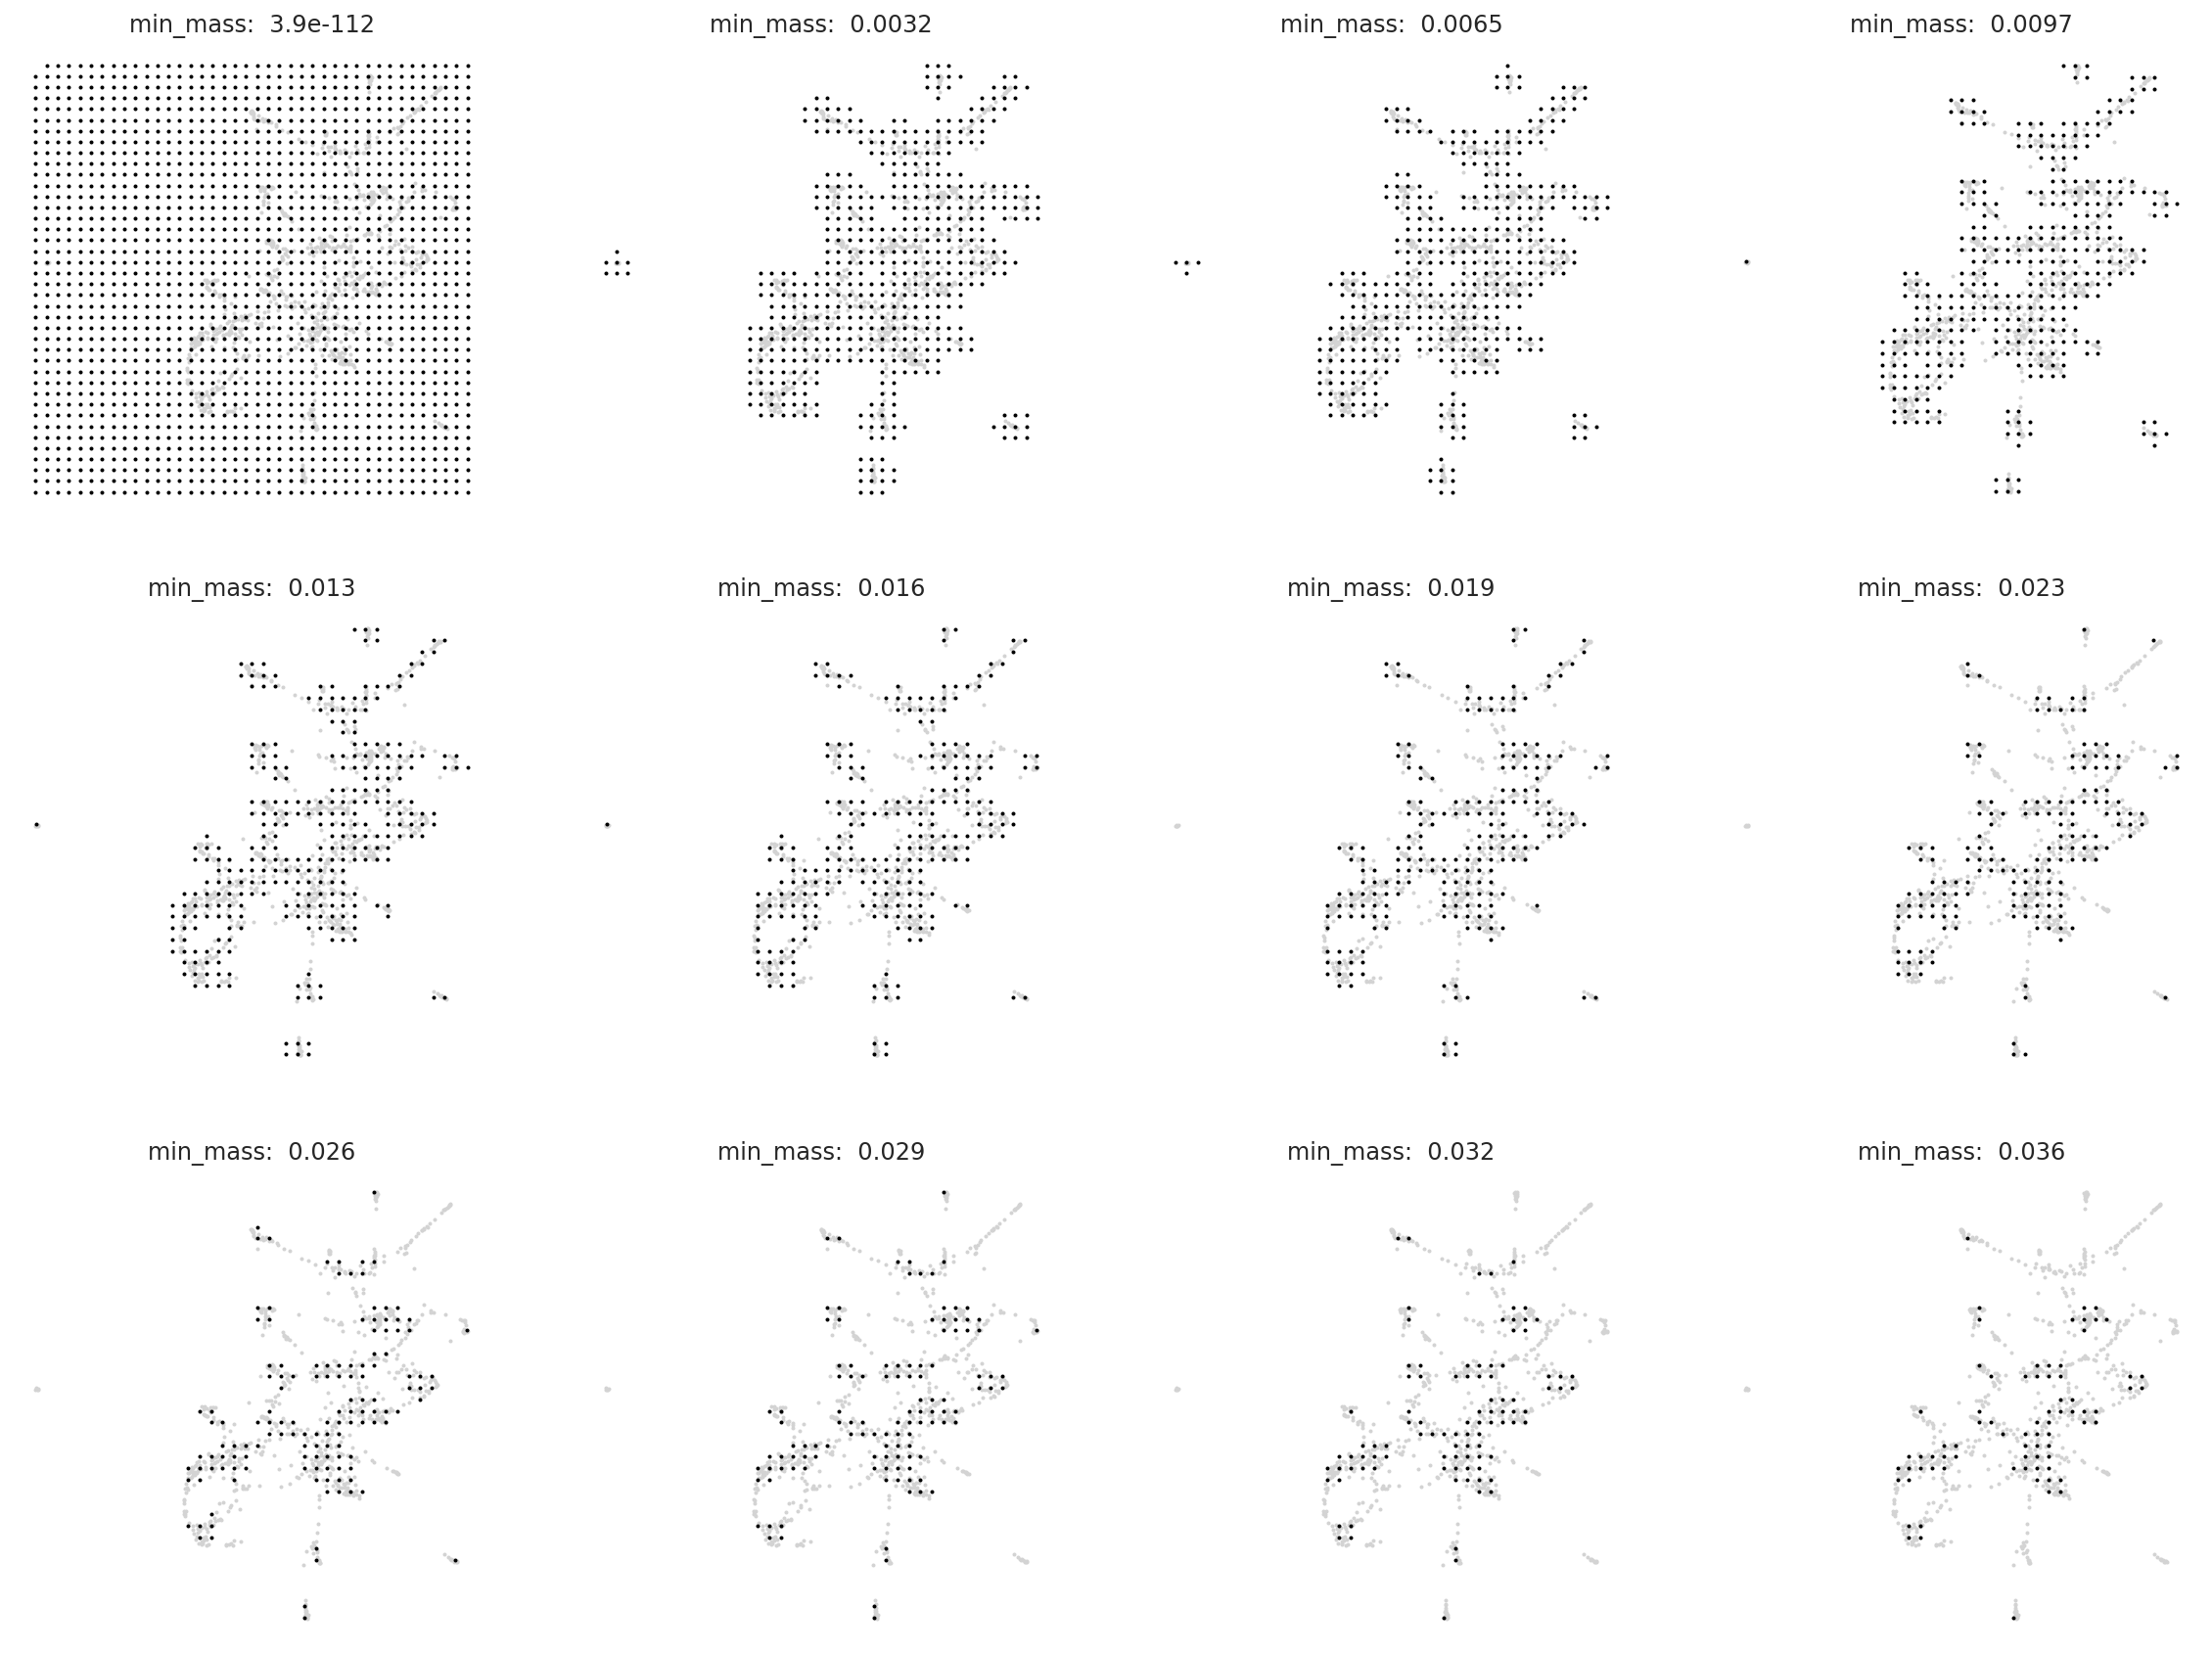

In [28]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

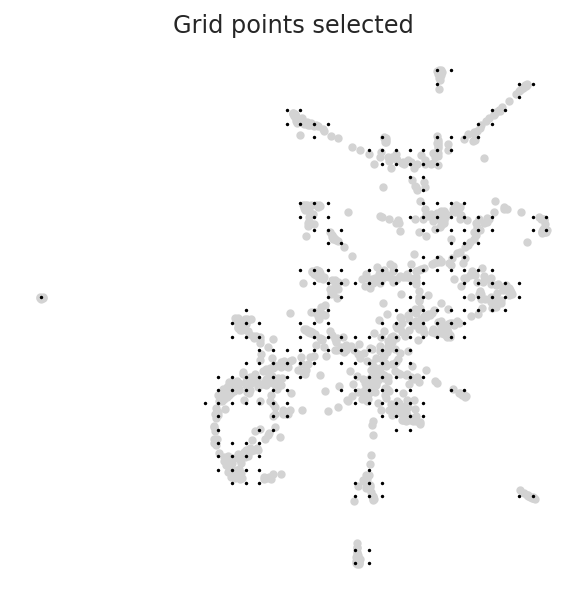

In [29]:
min_mass = 0.016
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

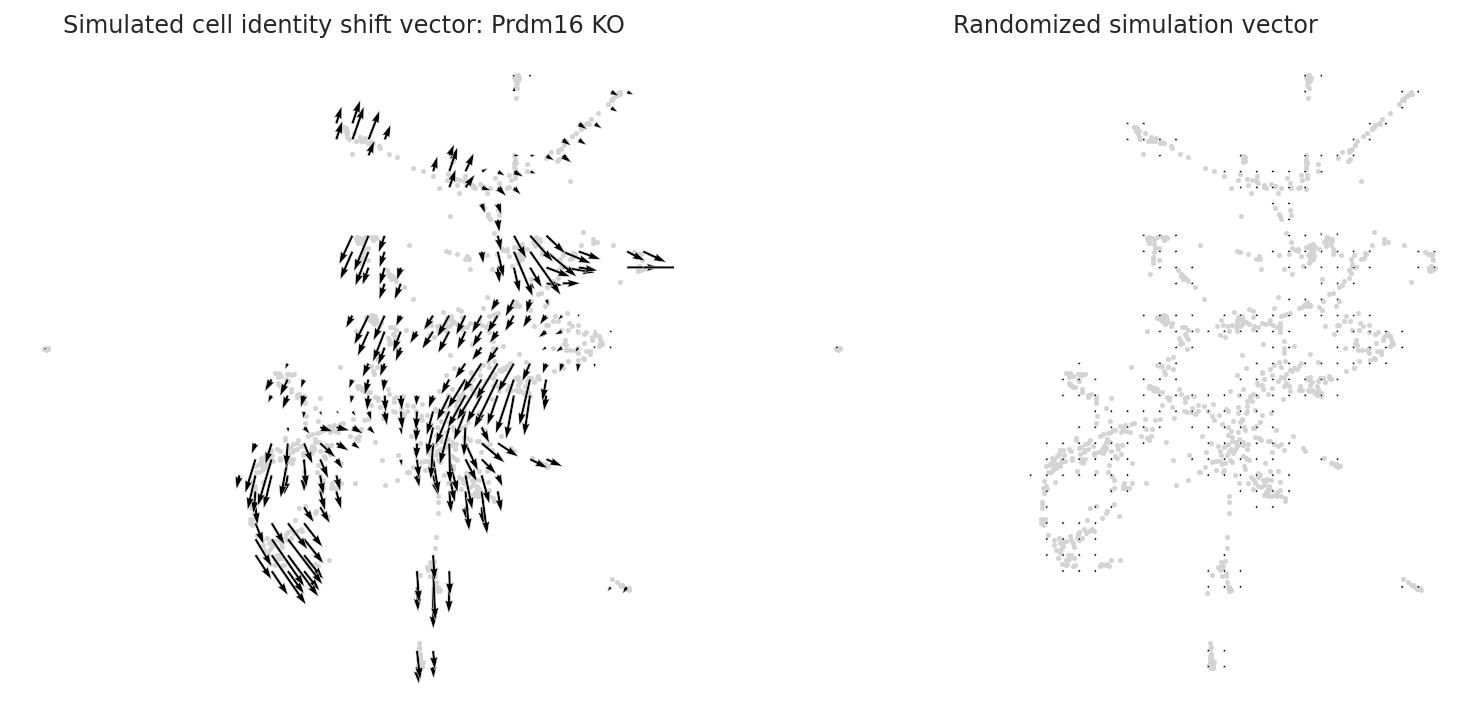

In [30]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

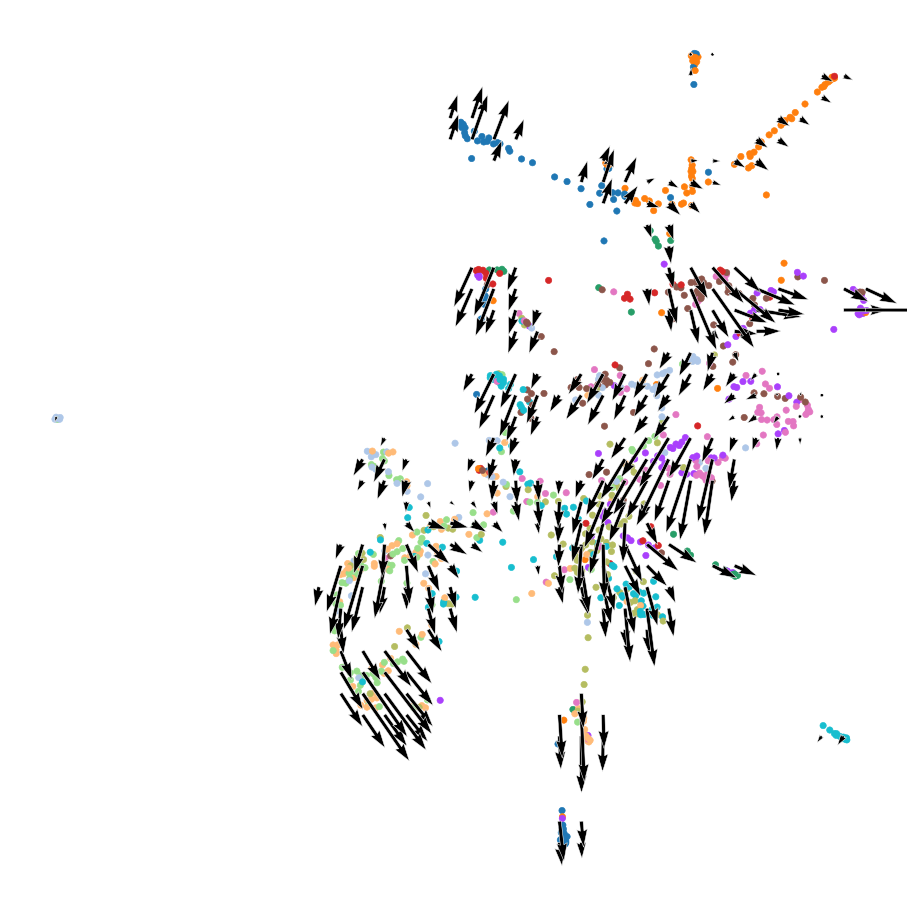

In [31]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [32]:
# save the model before pseudotime calculator
oracle.to_hdf5(file_path=f"{'intermedia_data'}.celloracle.oracle")

In [33]:
from celloracle.applications import Pseudotime_calculator

In [34]:
# Instantiate pseudotime object using oracle object.
oracle = co.load_hdf5("intermedia_data.celloracle.oracle")
oracle.embedding_name = 'X_draw_graph_fa'
pt = Pseudotime_calculator(oracle_object=oracle)
print("Clustering name: ", pt.cluster_column_name)
print("Cluster list", pt.cluster_list)

Clustering name:  timepoint
Cluster list ['e14', 'e18', 'p0', 'p11', 'p14', 'p18', 'p22', 'p28', 'p35', 'p4', 'p56', 'p8']


In [35]:
# Here, clusters can be classified into either MEP lineage or GMP lineage

clusters_Ery = ['e14', 'e18']
clusters_Pos = ['p0', 'p11', 'p14', 'p18', 'p22', 'p28', 'p35', 'p4', 'p56', 'p8']

# Make a dictionary
lineage_dictionary = {"Lineage_E": clusters_Ery ,
           "Lineage_P": clusters_Pos}

# Input lineage information into pseudotime object
pt.set_lineage(lineage_dictionary=lineage_dictionary)

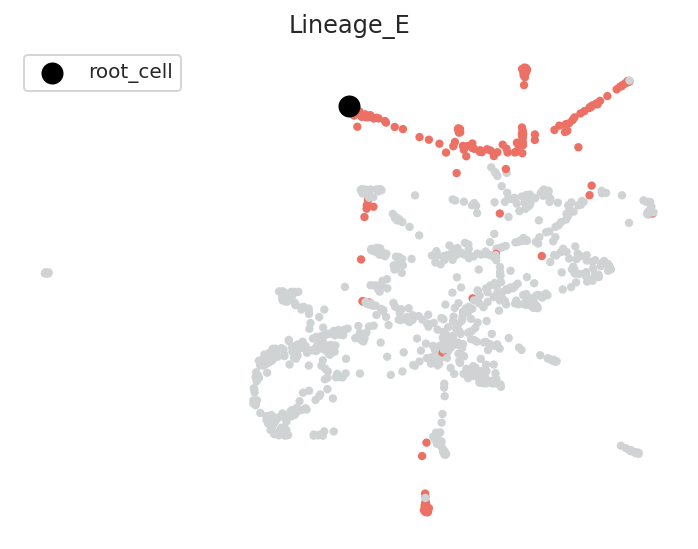

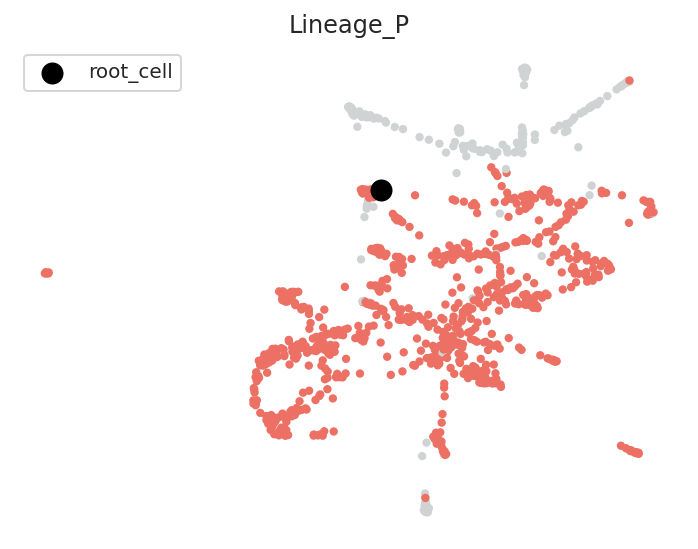

In [36]:
root_cells = {"Lineage_E": oracle.adata.obs.index[np.flatnonzero(oracle.adata.obs['timepoint'] == 'e14')[0]],
              "Lineage_P": oracle.adata.obs.index[np.flatnonzero(oracle.adata.obs['timepoint'] == 'p0')[0]]}
pt.set_root_cells(root_cells=root_cells)
# Check root cell and lineage
pt.plot_root_cells()

In [37]:
"X_diffmap" in pt.adata.obsm

True

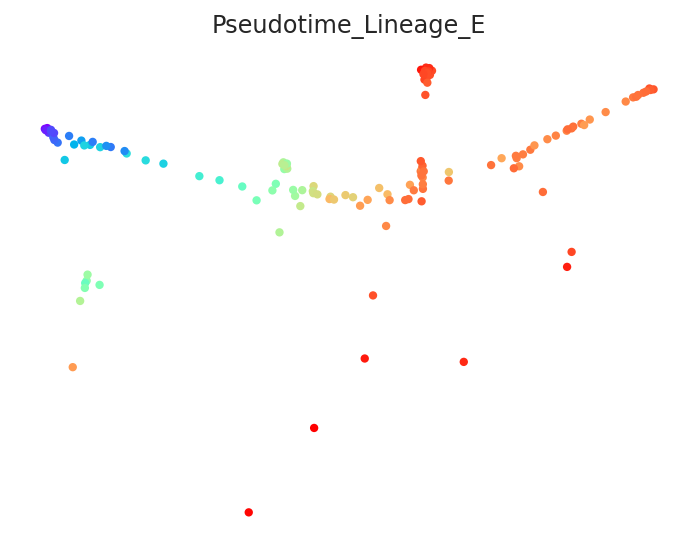

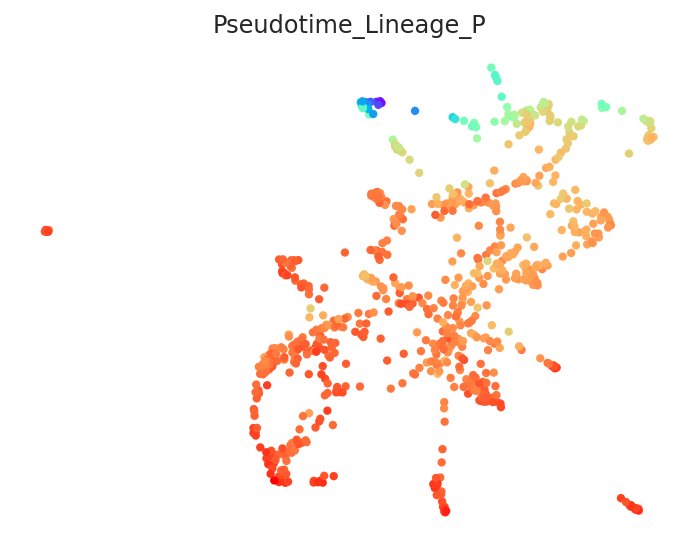

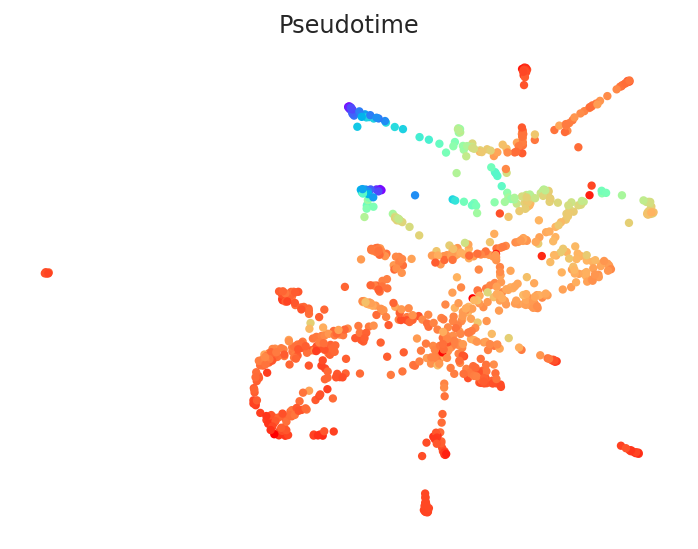

In [38]:
# Calculate pseudotime
pt.get_pseudotime_per_each_lineage()

# Check results
pt.plot_pseudotime(cmap="rainbow")
# Add calculated pseudotime data to the oracle object
oracle.adata.obs = pt.adata.obs

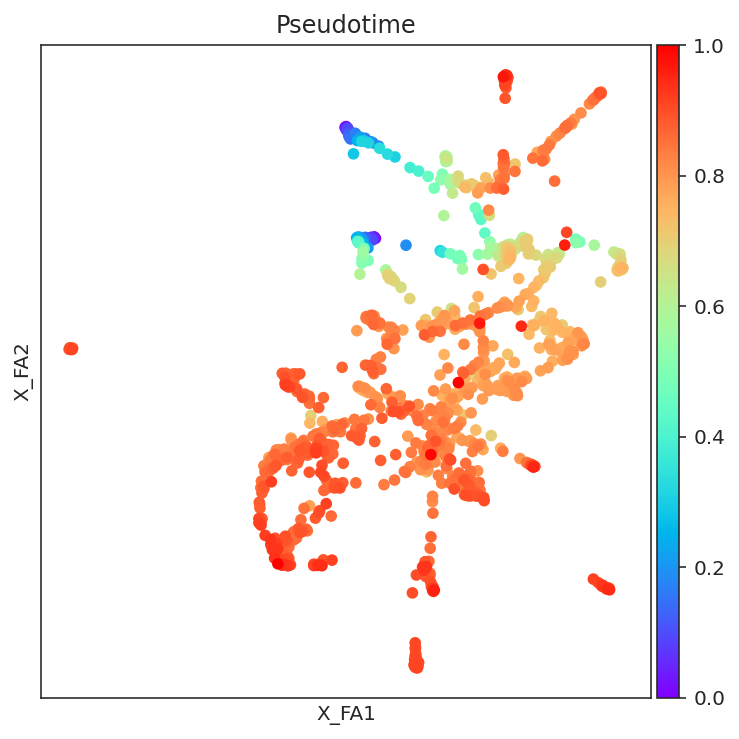

In [39]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

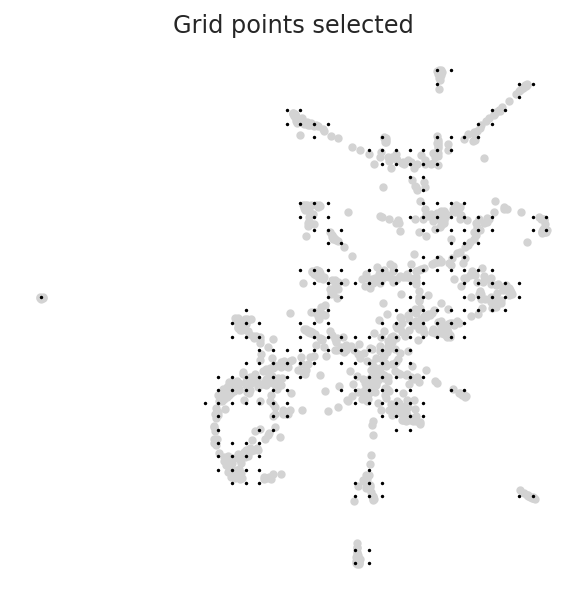

In [40]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)
gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})

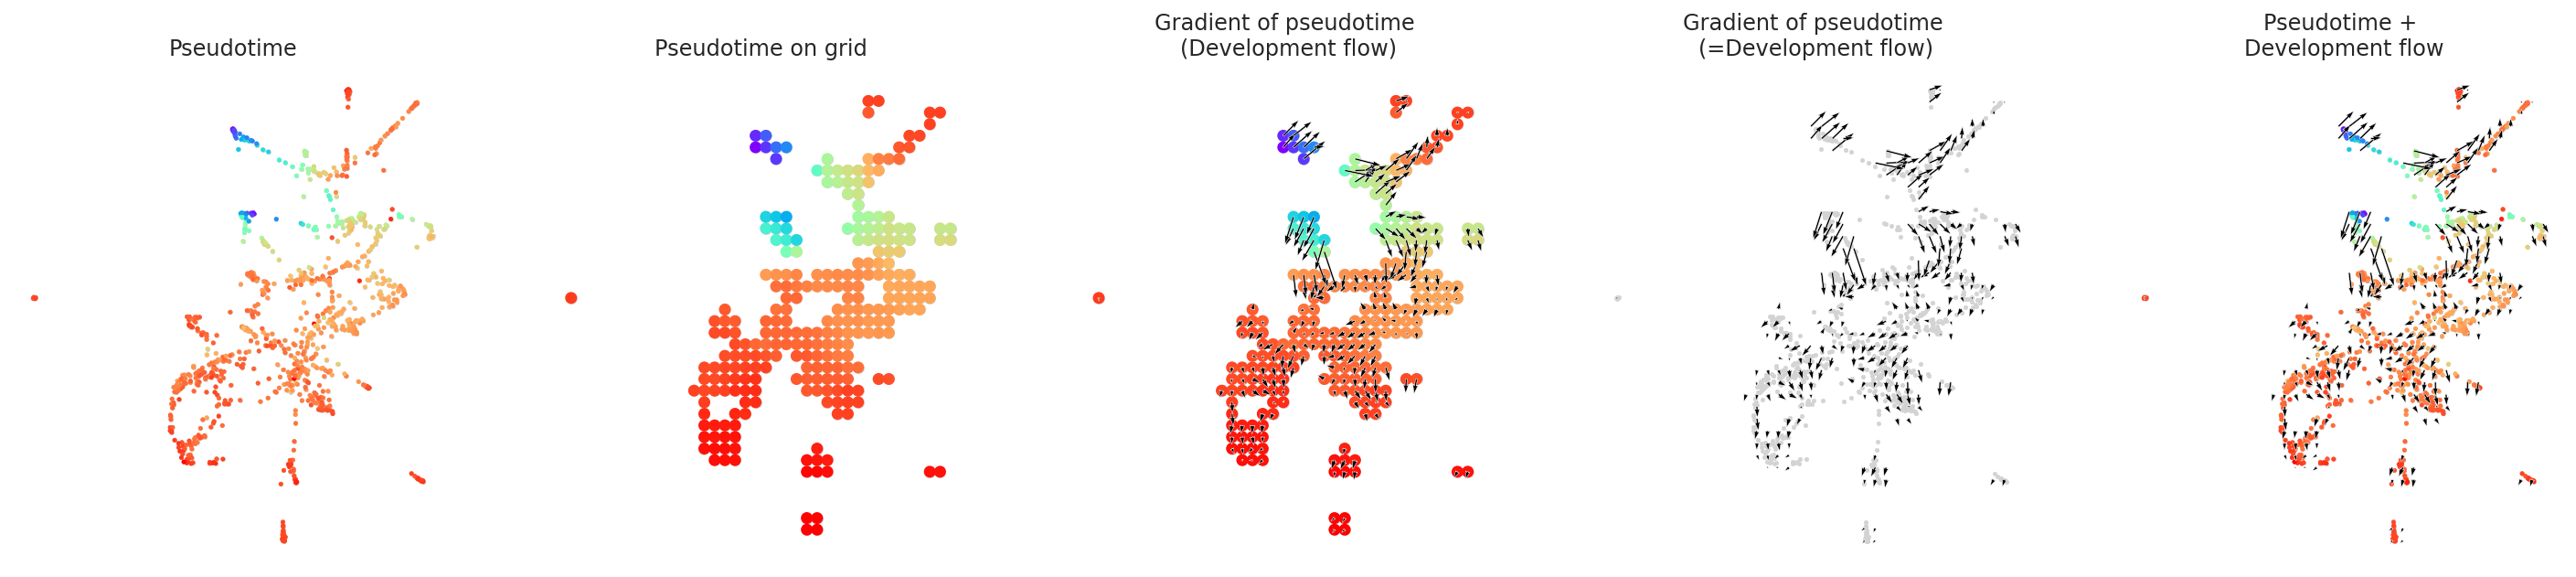

In [41]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

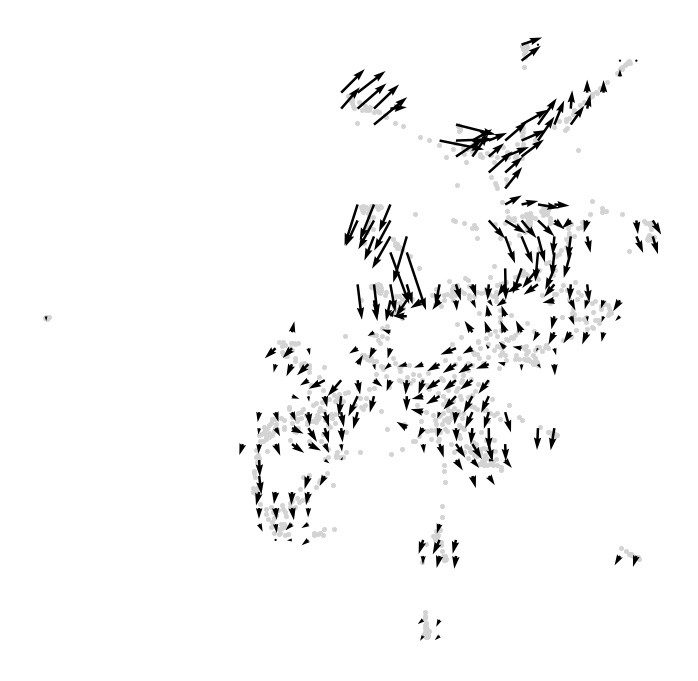

In [42]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [44]:
# Save gradient object if you want.
oracle_name = "Kannan_perinatal"
gradient.to_hdf5(file_path=f"{oracle_name}.celloracle.gradient")

In [ ]:
from celloracle.applications import Oracle_development_module

In [8]:

# Make Oracle_development_module to compare two vector field
oracle = co.load_hdf5("intermedia_data.celloracle.oracle")
gradient = co.load_hdf5("Kannan_perinatal.celloracle.gradient")
dev = Oracle_development_module(gradient_object=gradient,oracle_object=oracle)
# # Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=5)


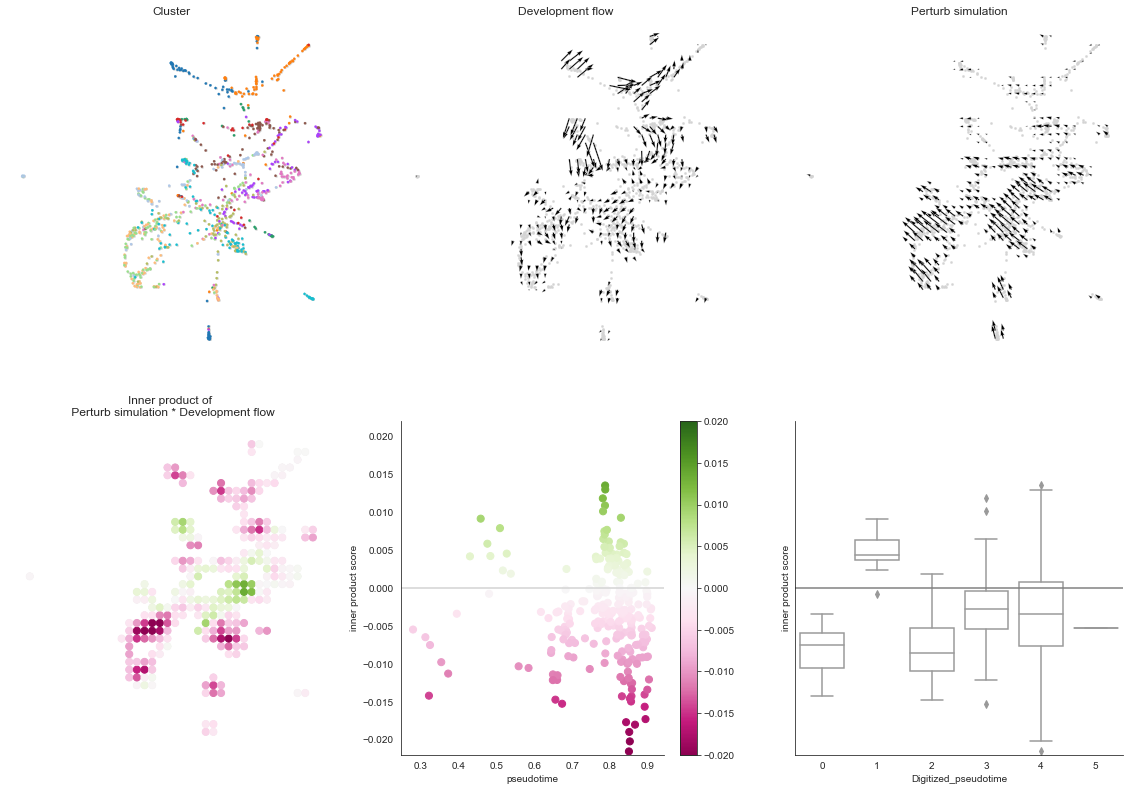

In [14]:
scale_simulation = 0.5
scale_dev = 40
# Let's visualize the results
dev.visualize_development_module_layout_0(s=5,
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev,
                                          vm=0.02,
                                          return_fig = True)
                                          

## Similarity measure
We will use 2D variable-wise Pearson Correlation for this.

For CellOracle validation, apply this to:

*   **Kannan (vitual-computational Prdm16-KO) vs Wu(real-experimntal Prdm16-KO)**


After CellOracle is validated, train a SECOND oracle on the engineered cardiomyocytes (CM), and for EACH speculative shift, use pearson_corr to compare to each Kannan timepoint. Success will drive the shifted transcriptome as close to the final stage of differention as possible.

We can also use the Kannan entropy metric in addition to/instead of this.

In [45]:
def pearson_corr(adata1, adata2):
    '''
    Calculate Pearson correlation of 2 anndata matrices
    
    Input:
    --------
    adata1: anndata object
    adata2: anndata object
    
    Output:
    --------
    float:
        Pearson correlation.
    '''
    #Extract matrices
    genes_list = np.intersect1d(adata1.var_names.tolist(),
                                adata2.var_names.tolist())

    A = adata1[:, genes_list].X
    B = adata2[:, genes_list].X

    A_mA = A - np.mean(A, axis=0)
    B_mB = B - np.mean(B, axis=0)

    # Sum of squares
    ssA = np.sum(np.power(A_mA, 2), axis=0)
    ssB = np.sum(np.power(B_mB, 2), axis=0)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssB, ssA[:, None]))

In [47]:
val_adata = sc.read_h5ad("wu_prdm16.h5ad")
train_data = co.load_hdf5("intermedia_data.celloracle.oracle")
train_adata = train_data.adata
p = pearson_corr(train_adata, val_adata)

In [99]:
np.mean(p)

-4.57997e-11

In [100]:
np.max(p)

0.013870225